# Unsupervised Learning and Dimensionality Reduction

In [56]:
import warnings
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score,f1_score,silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.decomposition import FastICA, PCA
from yellowbrick.features import pca_decomposition
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

In [2]:
def feature_engineering(file_name,NN=False):
    if file_name == 'Wine':
        data1 = pd.read_csv('wineQualityWhites.csv')
        data2 = pd.read_csv('wineQualityReds.csv')
        data = data1.append(data2)
        print("Number of rows in wine quality dataset: ", data.shape[0])
        print("Number of attributes in wine quality dataset: ", data.shape[1])
        data.quality = data.quality.apply(lambda x: 1 if x > 5 else 0)
    else:
        data = pd.read_csv('dataset.csv')
        print("Number of rows in pishing website dataset: ", data.shape[0])
        print("Number of attributes in pishing website dataset: ", data.shape[1])
        cols = ['URLURL_Length','having_Sub_Domain','SSLfinal_State','URL_of_Anchor','Links_in_tags','SFH','web_traffic','Links_pointing_to_page']
        data_1hot = data[cols]
        data_1hot = pd.get_dummies(data_1hot)
        df_others = data.drop(cols,axis=1)
        data = pd.concat([data_1hot,df_others],axis=1)
        data = data.replace(-1,0).astype('category')
        column_order = list(data)
        column_order.insert(0, column_order.pop(column_order.index('Result')))
        data = data.loc[:, column_order]
        data.describe(include='all')
    x_data = data.iloc[:,1:-1]
    y_data = data.iloc[:, -1]
    x_data = StandardScaler().fit_transform(x_data)
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, test_size=0.2, random_state=7, shuffle=True, stratify=y_data)
    if NN ==True:
        return x_data, y_data, x_train, x_test, y_train, y_test
    else:
        return x_train, x_test, y_train, y_test

In [3]:
def cluster_algorithm(X, y, dataset,algorithm):
    model_stats,model_metric = [],[]
    if dataset=='Wine':
        features = 11
    else:
        features = 31
    clustersizes = range(2, features)
    for clustersize in clustersizes:
        print("Running "+ algorithm +"- cluster size: " + str(clustersize))
        startTime = time.time()
        if algorithm == 'KMeans':
            Model = KMeans(n_clusters=clustersize, random_state=7)
        else:
            Model = GaussianMixture(n_components=clustersize, random_state=7)
        y_pred = Model.fit_predict(X)
        endTime = time.time()
        model_score = Model.score(X)
        run_time = endTime-startTime
        homeg_score = homogeneity_score(y, y_pred)
        v_measure = v_measure_score(y, y_pred)
        sil_score = silhouette_score(X=X, labels=y_pred, metric='euclidean', sample_size=X.shape[0])
        complete_score = completeness_score(labels_pred=y_pred, labels_true=y)
        assert (y.shape == y_pred.shape)
        pred = np.empty_like(y)
        for label in set(y_pred):
            mask = y_pred == label
            sub = y[mask]
            target = Counter(sub).most_common(1)[0][0]
            pred[mask] = target
        F1_score = f1_score(y, pred) 
        if algorithm == 'KMeans':
            distortion = Model.fit(X).inertia_ 
            model_metric.append(distortion)
        else:
            BIC = Model.bic(X)
            AIC = Model.aic(X)
            model_metric.append([BIC,AIC])
        model_stats.append([algorithm,clustersize,y_pred,run_time,homeg_score,v_measure,sil_score,complete_score,F1_score])
    df_model = pd.DataFrame(model_stats, columns=['algorithm','cluster_size','y_pred','run_time','homogeneity','vmeasure','silhouette','completeness','F1_score'])
    print(str(dataset) + " F1-score: "+algorithm + str(max(df_model["F1_score"])))
    return df_model,model_metric

In [4]:
def plot_alg_comparison(dataset,df1,df2,alg):
    plt.figure()
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].set_xlabel("No of clusters")
    axes[0].set_ylabel("Scores")
    axes[0].set_title("Scores v/s cluster size" + dataset)
    axes[0].plot(df1["cluster_size"], df1["silhouette"], '-o', label="KMeans silhouette score")    
    axes[0].plot(df2["cluster_size"], df2["silhouette"], '-o', label="EM silhouette score") 
    axes[0].plot(df1["cluster_size"], df1["homogeneity"], '-o', label="KMeans Homogeneity score")
    axes[0].plot(df2["cluster_size"], df2["homogeneity"], '-o', label="EM Homogeneity score")
    axes[0].plot(df1["cluster_size"], df1["vmeasure"], '-o', label="KMeans Vmeasure Score")
    axes[0].plot(df2["cluster_size"], df2["vmeasure"], '-o', label="EM Vmeasure Score")
    axes[0].plot(df1["cluster_size"], df1["completeness"], '-o', label="KMeans Completeness score")
    axes[0].plot(df2["cluster_size"], df2["completeness"], '-o', label="EM Completeness score")
    axes[0].legend(loc="best")
    
    axes[1].set_xlabel("No of clusters")
    axes[1].set_ylabel("F1-Score")
    axes[1].set_title("F1-Score v/s cluster size")
    axes[1].plot(df1["cluster_size"], df1["F1_score"], '-o', label="KMeans F1-Score")    
    axes[1].plot(df2["cluster_size"], df2["F1_score"], '-o', label="EM  F1-Score") 
    axes[1].legend(loc="best")
    
    axes[2].set_xlabel("No of clusters")
    axes[2].set_ylabel("Run Time")
    axes[2].set_title("Run time v/s cluster size" + dataset)
    axes[2].plot(df1["cluster_size"], df1["run_time"], '-o', label="KMeans Run time")    
    axes[2].plot(df2["cluster_size"], df2["run_time"], '-o', label="EM Run time")  
    axes[2].legend(loc="best")
    
    plt.savefig(dataset+alg+'KM_EM.png')
    plt.show()

In [5]:
x_wine_train, x_wine_test, y_wine_train, y_wine_test = feature_engineering('Wine')

Number of rows in wine quality dataset:  6497
Number of attributes in wine quality dataset:  13


In [6]:
df_wine_KMattr,df_wine_KMmetric = cluster_algorithm(x_wine_train, y_wine_train, 'Wine','KMeans')


Running KMeans- cluster size: 2
Running KMeans- cluster size: 3
Running KMeans- cluster size: 4
Running KMeans- cluster size: 5
Running KMeans- cluster size: 6
Running KMeans- cluster size: 7
Running KMeans- cluster size: 8
Running KMeans- cluster size: 9
Running KMeans- cluster size: 10
Wine F1-score: KMeans0.775303405207965


In [7]:
 df_wine_EMattr,df_wine_EMmetric= cluster_algorithm(x_wine_train, y_wine_train, 'Wine','Expectation Maximization')


Running Expectation Maximization- cluster size: 2
Running Expectation Maximization- cluster size: 3
Running Expectation Maximization- cluster size: 4
Running Expectation Maximization- cluster size: 5
Running Expectation Maximization- cluster size: 6
Running Expectation Maximization- cluster size: 7
Running Expectation Maximization- cluster size: 8
Running Expectation Maximization- cluster size: 9
Running Expectation Maximization- cluster size: 10
Wine F1-score: Expectation Maximization0.7807944362712317


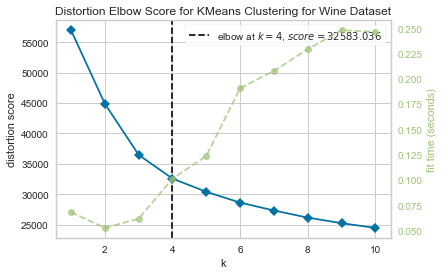

In [8]:
visualizer = kelbow_visualizer(KMeans(random_state=7), x_wine_train, k=(1, 11), title ="Distortion Elbow Score for KMeans Clustering for Wine Dataset")


<Figure size 432x288 with 0 Axes>

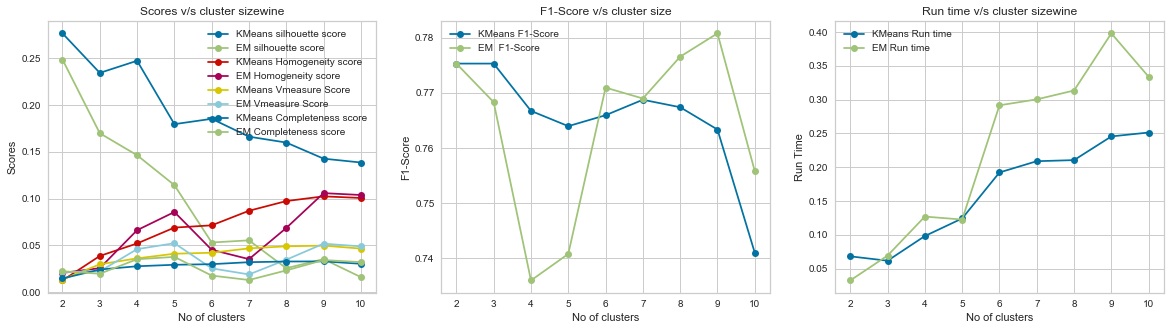

In [9]:
plot_alg_comparison("wine",df_wine_KMattr,df_wine_EMattr,'normal')

In [10]:
x_phish_train, x_phish_test, y_phish_train, y_phish_test = feature_engineering('Phishing')

Number of rows in pishing website dataset:  11055
Number of attributes in pishing website dataset:  32


In [11]:
df_phish_KMattr,df_phish_KMmetric = cluster_algorithm(x_phish_train, y_phish_train, 'Phishing','KMeans')

Running KMeans- cluster size: 2
Running KMeans- cluster size: 3
Running KMeans- cluster size: 4
Running KMeans- cluster size: 5
Running KMeans- cluster size: 6
Running KMeans- cluster size: 7
Running KMeans- cluster size: 8
Running KMeans- cluster size: 9
Running KMeans- cluster size: 10
Running KMeans- cluster size: 11
Running KMeans- cluster size: 12
Running KMeans- cluster size: 13
Running KMeans- cluster size: 14
Running KMeans- cluster size: 15
Running KMeans- cluster size: 16
Running KMeans- cluster size: 17
Running KMeans- cluster size: 18
Running KMeans- cluster size: 19
Running KMeans- cluster size: 20
Running KMeans- cluster size: 21
Running KMeans- cluster size: 22
Running KMeans- cluster size: 23
Running KMeans- cluster size: 24
Running KMeans- cluster size: 25
Running KMeans- cluster size: 26
Running KMeans- cluster size: 27
Running KMeans- cluster size: 28
Running KMeans- cluster size: 29
Running KMeans- cluster size: 30
Phishing F1-score: KMeans0.9375977968329473


In [12]:
 df_phish_EMattr,df_phish_EMmetric= cluster_algorithm(x_phish_train, y_phish_train, 'Phishing','Expectation Maximization')

Running Expectation Maximization- cluster size: 2
Running Expectation Maximization- cluster size: 3
Running Expectation Maximization- cluster size: 4
Running Expectation Maximization- cluster size: 5
Running Expectation Maximization- cluster size: 6
Running Expectation Maximization- cluster size: 7
Running Expectation Maximization- cluster size: 8
Running Expectation Maximization- cluster size: 9
Running Expectation Maximization- cluster size: 10
Running Expectation Maximization- cluster size: 11
Running Expectation Maximization- cluster size: 12
Running Expectation Maximization- cluster size: 13
Running Expectation Maximization- cluster size: 14
Running Expectation Maximization- cluster size: 15
Running Expectation Maximization- cluster size: 16
Running Expectation Maximization- cluster size: 17
Running Expectation Maximization- cluster size: 18
Running Expectation Maximization- cluster size: 19
Running Expectation Maximization- cluster size: 20
Running Expectation Maximization- clust

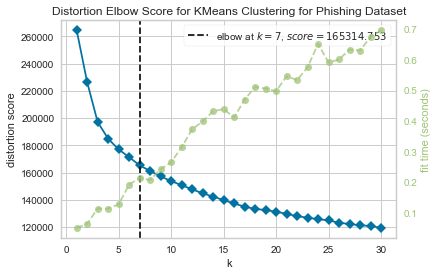

In [13]:
visualizer = kelbow_visualizer(KMeans(random_state=7), x_phish_train, k=(1, 31), title ="Distortion Elbow Score for KMeans Clustering for Phishing Dataset")


<Figure size 432x288 with 0 Axes>

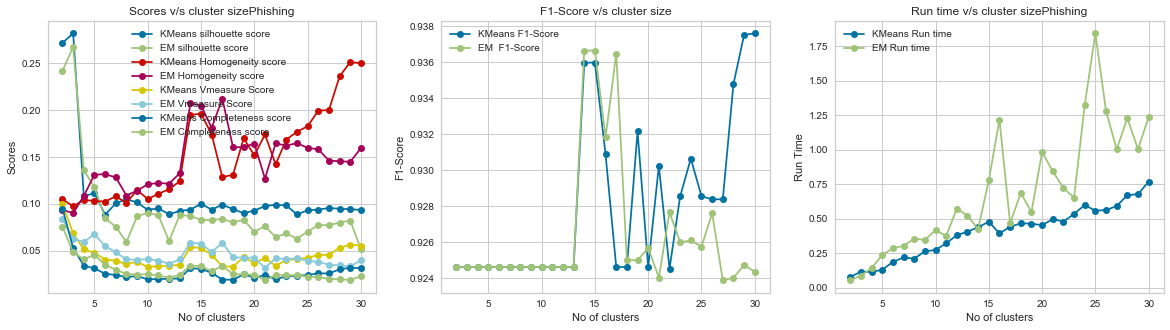

In [14]:
plot_alg_comparison("Phishing",df_phish_KMattr,df_phish_EMattr,'normal')

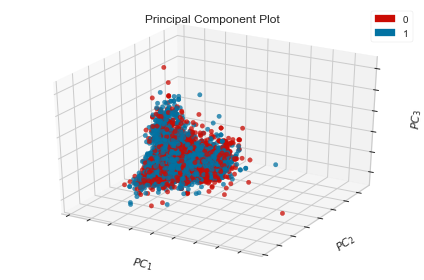

/Users/sachin_divz/anaconda3/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PCA(ax=<matplotlib.axes._subplots.Axes3DSubplot object at 0x7fd48802b128>,
    classes=[0, 1], colors=['r', 'b'], projection=3)

In [15]:
pca_decomposition(x_wine_train, y_wine_train,classes=[0,1], colors=['r', 'b'], projection=3)

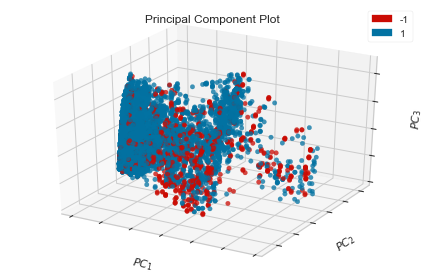

/Users/sachin_divz/anaconda3/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PCA(ax=<matplotlib.axes._subplots.Axes3DSubplot object at 0x7fd4881020b8>,
    classes=[-1, 1], colors=['r', 'b'], projection=3)

In [16]:
pca_decomposition(x_phish_train, y_phish_train,classes=[-1,1], colors=['r', 'b'], projection=3)

In [17]:
def plot_pca(pca, dataset):
    fig, ax = plt.subplots()
    ax.title.set_text("Variance by PCA Components - " + dataset)
    ax2 = ax.twinx()
    features = range(pca.n_components_)
    var_cum = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))
    ax.bar(features, pca.explained_variance_ratio_)
    ax2.plot(var_cum, marker='o')
    ax.set_xlabel('PCA features')
    ax.set_xticks(features)
    ax.set_ylabel('By Component Variance %')
    ax2.set_ylabel('Cumulative Variance %')
    plt.show()
    return plt

In [18]:
def plot_scatter(X_clustered, X_data, dataset, estimator_name):
    plt.figure()
    color_map = {0:'#1f77b4',1: '#ff7f0e',2: '#2ca02c',3: '#d62728',4:'#9467bd',5: '#8c564b',6: '#e377c2',7: '#7f7f7f',8: '#bcbd22',9: '#17becf',10:'#efdecd',11:'#a4c639', 12:'#915c83', 13:'#00ffff',14:'#f5f5dc'}
    label_color = [color_map[l] for l in X_clustered]
    label = ['cluster %s' % (l) for l in X_clustered]
    plt.title("Scatter Plot of Clusters for %s using %s" %(dataset, estimator_name))
    plt.scatter(X_data[:, 0], X_data[:, 1], c = label_color, alpha=0.5)
    plt.savefig("figures/clusters/" + str(dataset)+"_"+ str(estimator_name)+".png")
    plt.show()
    plt.close()

In [19]:
def plot_kutosis(compnts, kurtosis, dataset):
    plt.figure(figsize=(6, 6))
    plt.plot(compnts, kurtosis, linestyle='-', marker='o')
    plt.xlabel('Components')
    plt.ylabel('Kurtosis')
    plt.minorticks_on()
    plt.grid(b=True, which='major', color='k', linestyle='-', alpha=0.1)
    plt.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.05)
    plt.title(dataset+"Kurtosis vs Components")
    plt.show()
    plt.close()

In [20]:
def plot_reconstr_error(compnts, err, dataset):
    plt.figure(figsize=(6, 6))
    plt.plot(compnts, err, linestyle='-', marker='o')
    plt.xlabel('Components')
    plt.ylabel('Reconstruction Error')
    plt.minorticks_on()
    plt.grid(b=True, which='major', color='k', linestyle='-', alpha=0.1)
    plt.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.05)
    plt.title(dataset+"Reconstruction Error vs Components")
    plt.show()
    plt.close()

In [21]:
def plot_feature_imp(X, importances,indices,labels, dataset):
    plt.title(dataset+'Feature Importances')
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), labels, rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()
    plt.show()
    plt.close()

In [50]:
def Dimensionality_reduction(X, y, dataset, Dim_Redc):
    if dataset == "Wine":
        features = 10
        classes=[0,1]
    else:
        features = 30
        classes=[-1,1]
    if Dim_Redc == 'PCA':  
        Pca = PCA(n_components=features)
        fitted_pca = Pca.fit_transform(X) 
        pca_wine_var_plot = plot_pca(Pca, dataset)
        if dataset == "Wine":
            features = 6
        else:
            features = 16
        fitted_x = PCA(n_components=features).fit_transform(X=X)
    elif Dim_Redc == 'ICA':
        components = list(np.arange(1,(X.shape[1]),1))
        kurtosis = []
        for c in components:
            fitted_ica = FastICA(n_components=c).fit_transform(X)
            temp = pd.DataFrame(fitted_ica)
            temp = temp.kurt(axis=0)
            kurtosis.append(temp.abs().mean())
        plot_kutosis(components, kurtosis, dataset)
        if dataset == "Wine":
            features = 4
        else:
            features = 13
        fitted_x = FastICA(n_components = features,random_state=7).fit_transform(X)
    elif Dim_Redc == 'RP':
        components = list(np.arange(1,(X.shape[1]),1))
        error = []
        for c in components:
            rp = GaussianRandomProjection(n_components=c)
            fitted_rp = rp.fit_transform(X)
            reconstruction = np.dot(fitted_rp, rp.components_)  
            reconstruction_err = np.mean((X - reconstruction)**2)  
            error.append(reconstruction_err) 
        plot_reconstr_error(components, error, dataset)
        if dataset == "Wine":
            features = 4
        else:
            features = 15
        fitted_x = SparseRandomProjection(n_components=features).fit_transform(X)
    elif Dim_Redc == 'RF': 
        if dataset == "Wine":
            features = 5
            df_white = pd.read_csv('wineQualityWhites.csv')
            df_red = pd.read_csv('wineQualityReds.csv')
            df = df_white.append(df_red)
        else:
            features = 16
            df = pd.read_csv('dataset.csv').astype('category')
        labels = df.columns[1:]
        rf = RandomForestClassifier(max_depth=10, ccp_alpha=0.002, criterion='entropy')
        rf.fit(X, y)
        feature_imp = rf.feature_importances_
        idx = np.argsort(feature_imp)[::-1]
        plot_feature_imp(X,feature_imp,idx,labels,dataset)
        srf = SelectFromModel(rf, threshold=0.05)
        srf.fit(X, y)
        fitted_x = srf.transform(X)
        
    df_KMattr,df_KMmetric = cluster_algorithm(fitted_x, y, dataset,'KMeans')
    df_EMattr,df_EMmetric = cluster_algorithm(fitted_x, y, dataset,'Expectation Maximization')
    plot_alg_comparison(dataset,df_KMattr,df_EMattr,Dim_Redc)

    em = GaussianMixture(n_components=2, random_state=7,max_iter=100)
    x_clusters = em.fit_predict(fitted_x)
    plot_scatter(X_clustered=x_clusters, X_data=fitted_x, dataset=dataset, estimator_name="EM_with_"+Dim_Redc)
        
    km = KMeans(n_clusters=2, random_state=7,max_iter=100)
    x_clusters = km.fit_predict(fitted_x)
    plot_scatter(X_clustered=x_clusters, X_data=fitted_x, dataset=dataset, estimator_name="Kmeans_with_"+Dim_Redc)
        
    pca_decomposition(fitted_x, y,classes=classes, colors=['r', 'b'], projection=3)

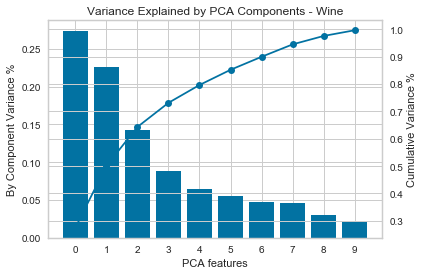

Running KMeans- cluster size: 2
Running KMeans- cluster size: 3
Running KMeans- cluster size: 4
Running KMeans- cluster size: 5
Running KMeans- cluster size: 6
Running KMeans- cluster size: 7
Running KMeans- cluster size: 8
Running KMeans- cluster size: 9
Running KMeans- cluster size: 10
Wine F1-score: KMeans0.775303405207965
Running Expectation Maximization- cluster size: 2
Running Expectation Maximization- cluster size: 3
Running Expectation Maximization- cluster size: 4
Running Expectation Maximization- cluster size: 5
Running Expectation Maximization- cluster size: 6
Running Expectation Maximization- cluster size: 7
Running Expectation Maximization- cluster size: 8
Running Expectation Maximization- cluster size: 9
Running Expectation Maximization- cluster size: 10
Wine F1-score: Expectation Maximization0.775303405207965


<Figure size 432x288 with 0 Axes>

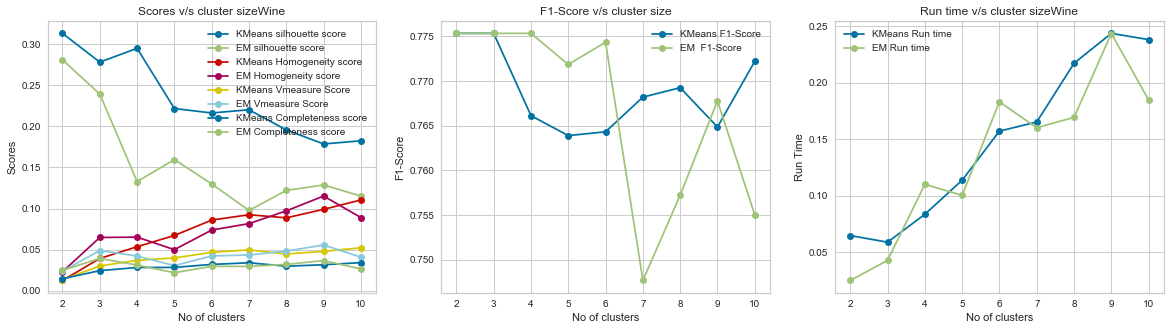

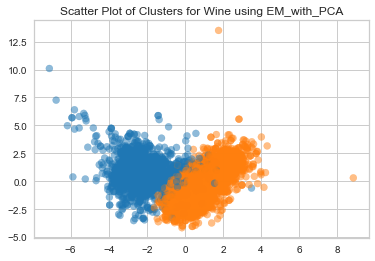

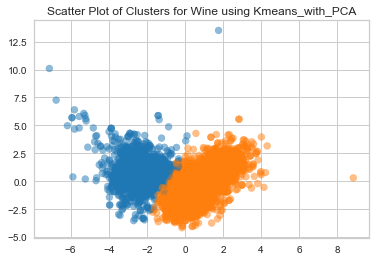

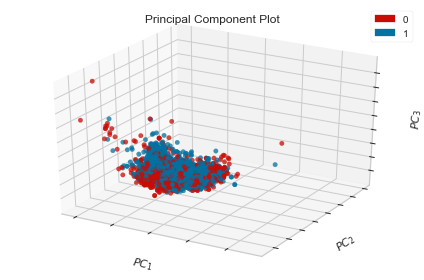

In [32]:
Dimensionality_reduction(x_wine_train, y_wine_train, 'Wine', 'PCA')

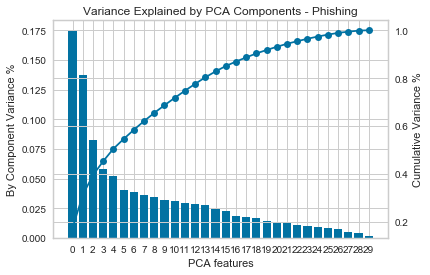

Running KMeans- cluster size: 2
Running KMeans- cluster size: 3
Running KMeans- cluster size: 4
Running KMeans- cluster size: 5
Running KMeans- cluster size: 6
Running KMeans- cluster size: 7
Running KMeans- cluster size: 8
Running KMeans- cluster size: 9
Running KMeans- cluster size: 10
Running KMeans- cluster size: 11
Running KMeans- cluster size: 12
Running KMeans- cluster size: 13
Running KMeans- cluster size: 14
Running KMeans- cluster size: 15
Running KMeans- cluster size: 16
Running KMeans- cluster size: 17
Running KMeans- cluster size: 18
Running KMeans- cluster size: 19
Running KMeans- cluster size: 20
Running KMeans- cluster size: 21
Running KMeans- cluster size: 22
Running KMeans- cluster size: 23
Running KMeans- cluster size: 24
Running KMeans- cluster size: 25
Running KMeans- cluster size: 26
Running KMeans- cluster size: 27
Running KMeans- cluster size: 28
Running KMeans- cluster size: 29
Running KMeans- cluster size: 30
Phishing F1-score: KMeans0.940768308837444
Running 

<Figure size 432x288 with 0 Axes>

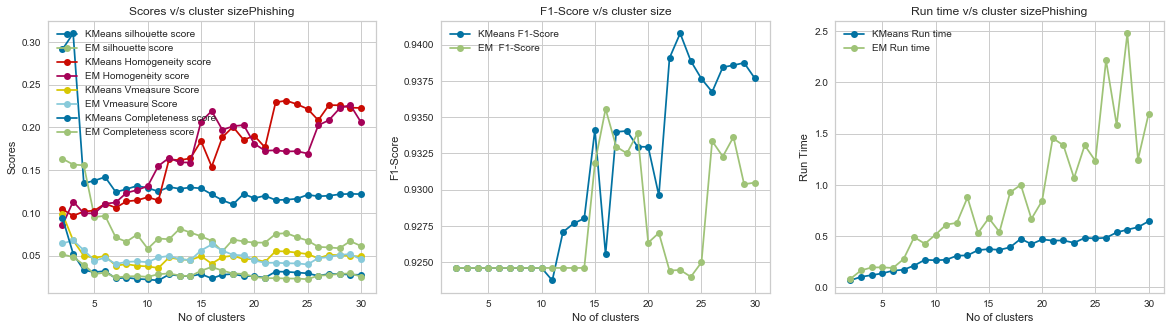

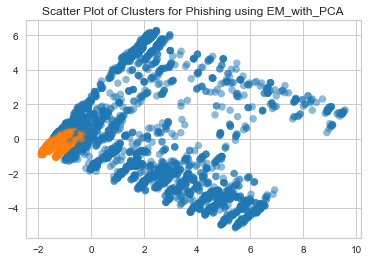

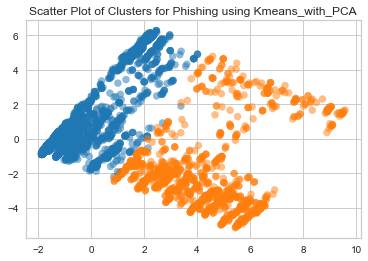

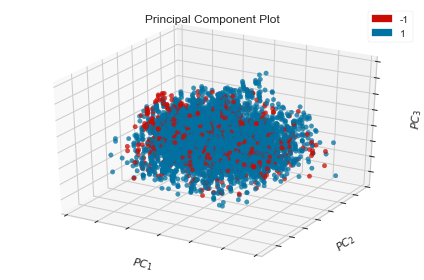

In [33]:
Dimensionality_reduction(x_phish_train, y_phish_train, 'Phishing', 'PCA')

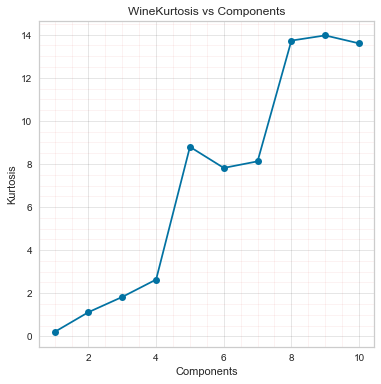

Running KMeans- cluster size: 2
Running KMeans- cluster size: 3
Running KMeans- cluster size: 4
Running KMeans- cluster size: 5
Running KMeans- cluster size: 6
Running KMeans- cluster size: 7
Running KMeans- cluster size: 8
Running KMeans- cluster size: 9
Running KMeans- cluster size: 10
Wine F1-score: KMeans0.775303405207965
Running Expectation Maximization- cluster size: 2
Running Expectation Maximization- cluster size: 3
Running Expectation Maximization- cluster size: 4
Running Expectation Maximization- cluster size: 5
Running Expectation Maximization- cluster size: 6
Running Expectation Maximization- cluster size: 7
Running Expectation Maximization- cluster size: 8
Running Expectation Maximization- cluster size: 9
Running Expectation Maximization- cluster size: 10
Wine F1-score: Expectation Maximization0.7754094099298156


<Figure size 432x288 with 0 Axes>

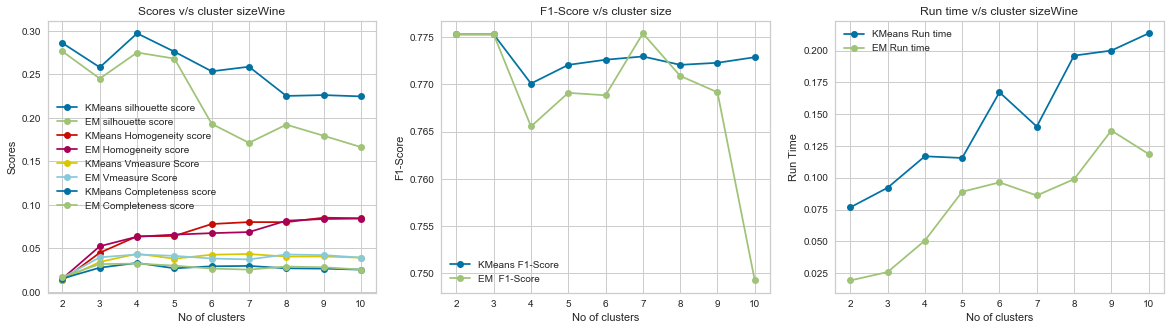

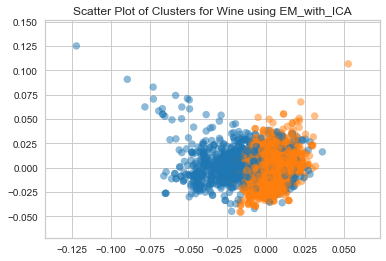

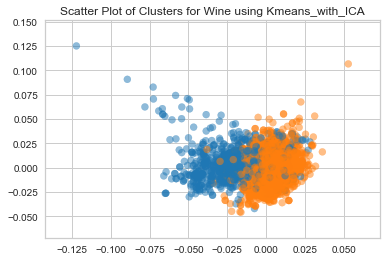

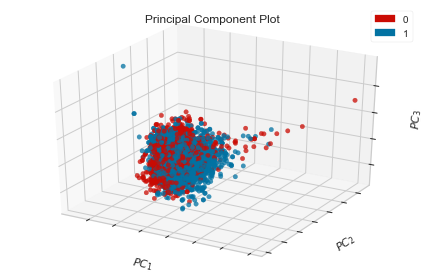

In [35]:
Dimensionality_reduction(x_wine_train, y_wine_train, 'Wine', 'ICA')

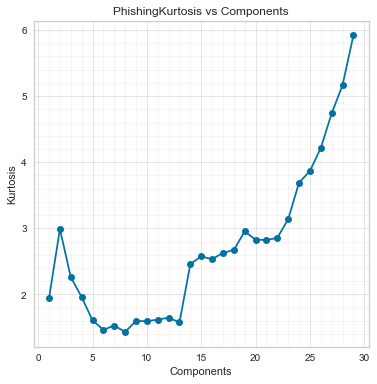

Running KMeans- cluster size: 2
Running KMeans- cluster size: 3
Running KMeans- cluster size: 4
Running KMeans- cluster size: 5
Running KMeans- cluster size: 6
Running KMeans- cluster size: 7
Running KMeans- cluster size: 8
Running KMeans- cluster size: 9
Running KMeans- cluster size: 10
Running KMeans- cluster size: 11
Running KMeans- cluster size: 12
Running KMeans- cluster size: 13
Running KMeans- cluster size: 14
Running KMeans- cluster size: 15
Running KMeans- cluster size: 16
Running KMeans- cluster size: 17
Running KMeans- cluster size: 18
Running KMeans- cluster size: 19
Running KMeans- cluster size: 20
Running KMeans- cluster size: 21
Running KMeans- cluster size: 22
Running KMeans- cluster size: 23
Running KMeans- cluster size: 24
Running KMeans- cluster size: 25
Running KMeans- cluster size: 26
Running KMeans- cluster size: 27
Running KMeans- cluster size: 28
Running KMeans- cluster size: 29
Running KMeans- cluster size: 30
Phishing F1-score: KMeans0.937977276960328
Running 

<Figure size 432x288 with 0 Axes>

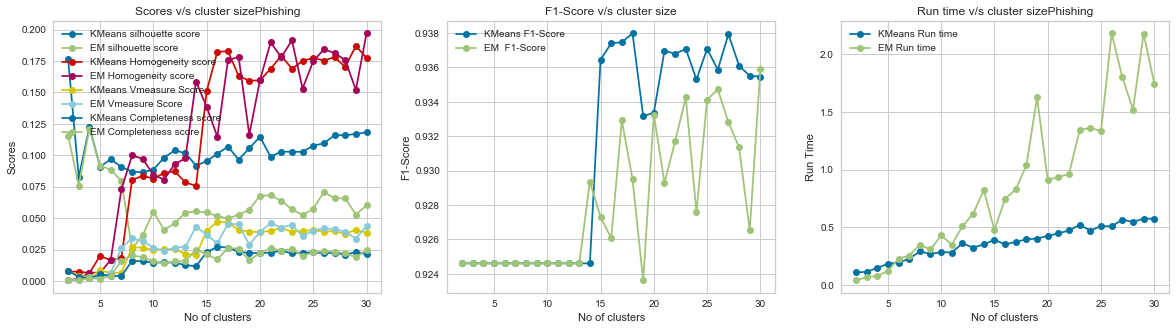

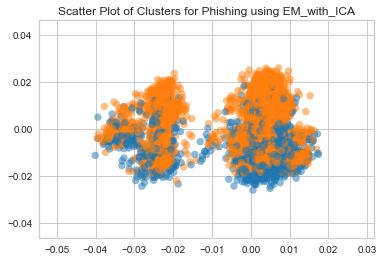

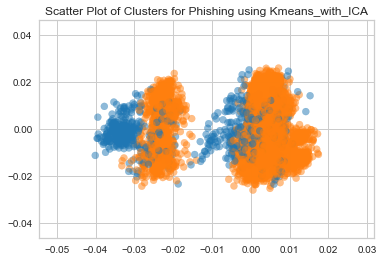

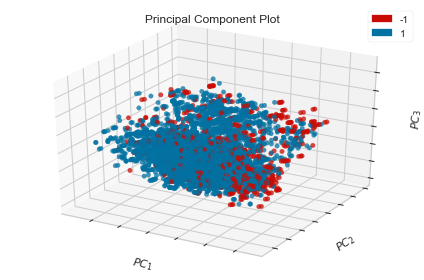

In [36]:
Dimensionality_reduction(x_phish_train, y_phish_train, 'Phishing', 'ICA')

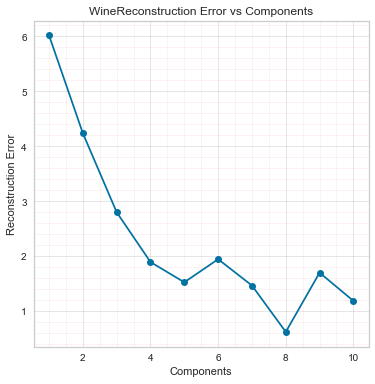

Running KMeans- cluster size: 2
Running KMeans- cluster size: 3
Running KMeans- cluster size: 4
Running KMeans- cluster size: 5
Running KMeans- cluster size: 6
Running KMeans- cluster size: 7
Running KMeans- cluster size: 8
Running KMeans- cluster size: 9
Running KMeans- cluster size: 10
Wine F1-score: KMeans0.775303405207965
Running Expectation Maximization- cluster size: 2
Running Expectation Maximization- cluster size: 3
Running Expectation Maximization- cluster size: 4
Running Expectation Maximization- cluster size: 5
Running Expectation Maximization- cluster size: 6
Running Expectation Maximization- cluster size: 7
Running Expectation Maximization- cluster size: 8
Running Expectation Maximization- cluster size: 9
Running Expectation Maximization- cluster size: 10
Wine F1-score: Expectation Maximization0.775303405207965


<Figure size 432x288 with 0 Axes>

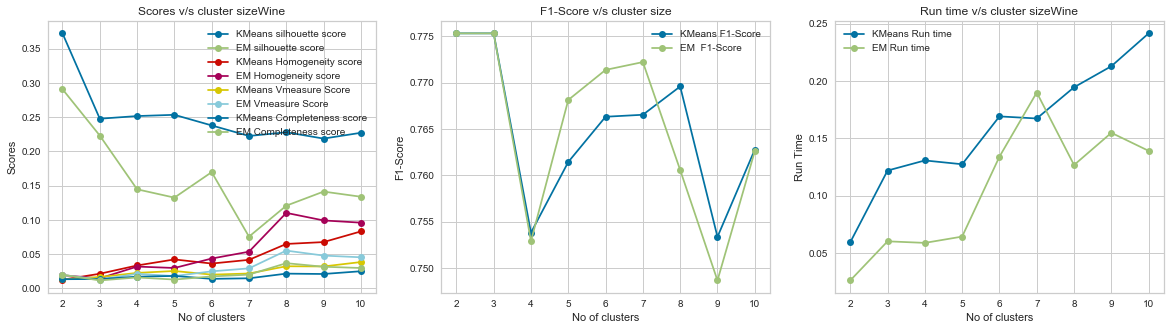

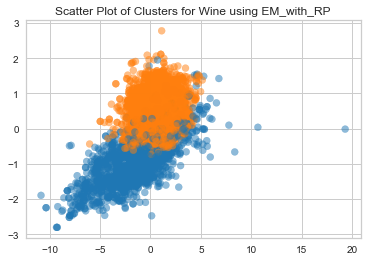

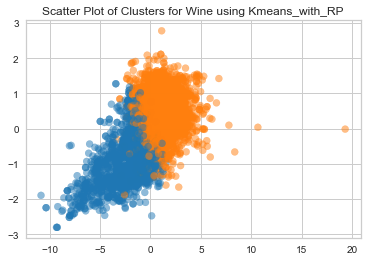

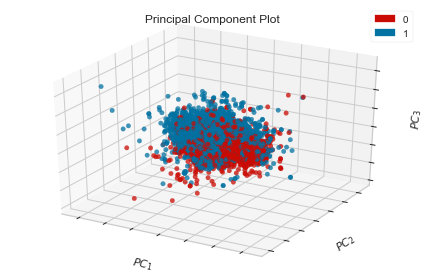

In [45]:
Dimensionality_reduction(x_wine_train, y_wine_train, 'Wine', 'RP')

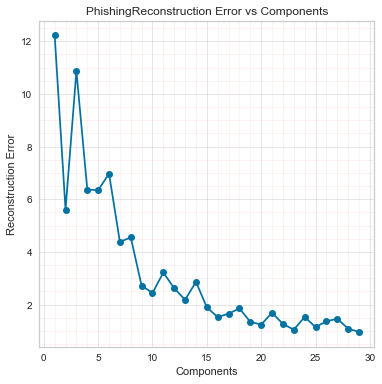

Running KMeans- cluster size: 2
Running KMeans- cluster size: 3
Running KMeans- cluster size: 4
Running KMeans- cluster size: 5
Running KMeans- cluster size: 6
Running KMeans- cluster size: 7
Running KMeans- cluster size: 8
Running KMeans- cluster size: 9
Running KMeans- cluster size: 10
Running KMeans- cluster size: 11
Running KMeans- cluster size: 12
Running KMeans- cluster size: 13
Running KMeans- cluster size: 14
Running KMeans- cluster size: 15
Running KMeans- cluster size: 16
Running KMeans- cluster size: 17
Running KMeans- cluster size: 18
Running KMeans- cluster size: 19
Running KMeans- cluster size: 20
Running KMeans- cluster size: 21
Running KMeans- cluster size: 22
Running KMeans- cluster size: 23
Running KMeans- cluster size: 24
Running KMeans- cluster size: 25
Running KMeans- cluster size: 26
Running KMeans- cluster size: 27
Running KMeans- cluster size: 28
Running KMeans- cluster size: 29
Running KMeans- cluster size: 30
Phishing F1-score: KMeans0.9330125364062303
Running

<Figure size 432x288 with 0 Axes>

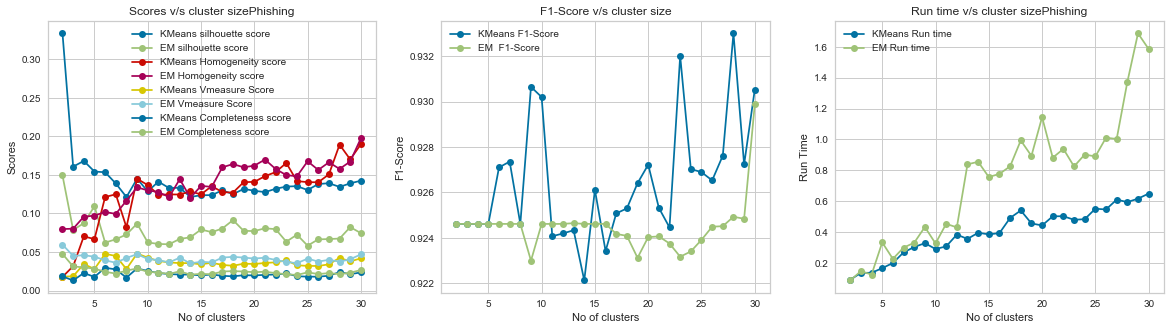

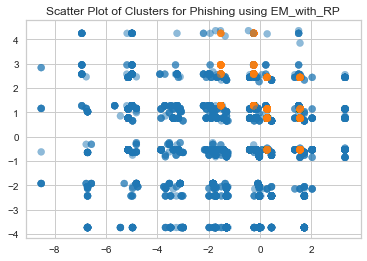

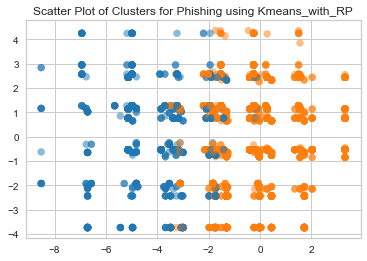

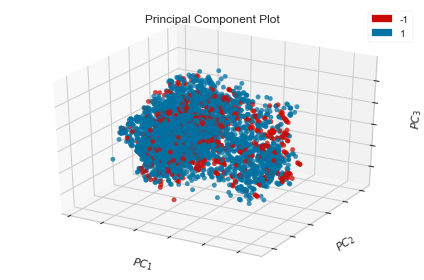

In [48]:
Dimensionality_reduction(x_phish_train, y_phish_train, 'Phishing', 'RP')

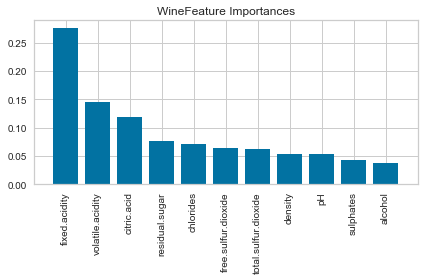

Running KMeans- cluster size: 2
Running KMeans- cluster size: 3
Running KMeans- cluster size: 4
Running KMeans- cluster size: 5
Running KMeans- cluster size: 6
Running KMeans- cluster size: 7
Running KMeans- cluster size: 8
Running KMeans- cluster size: 9
Running KMeans- cluster size: 10
Wine F1-score: KMeans0.775303405207965
Running Expectation Maximization- cluster size: 2
Running Expectation Maximization- cluster size: 3
Running Expectation Maximization- cluster size: 4
Running Expectation Maximization- cluster size: 5
Running Expectation Maximization- cluster size: 6
Running Expectation Maximization- cluster size: 7
Running Expectation Maximization- cluster size: 8
Running Expectation Maximization- cluster size: 9
Running Expectation Maximization- cluster size: 10
Wine F1-score: Expectation Maximization0.775303405207965


<Figure size 432x288 with 0 Axes>

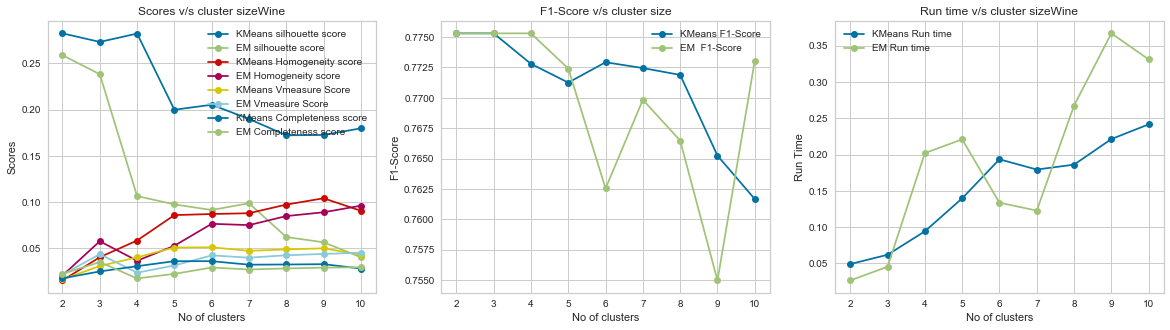

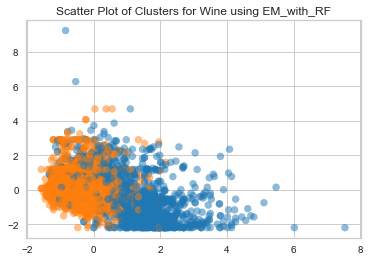

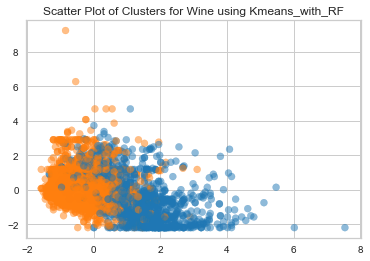

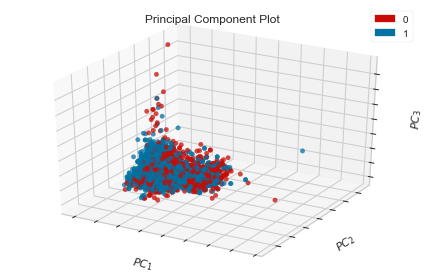

In [51]:
Dimensionality_reduction(x_wine_train, y_wine_train, 'Wine', 'RF')

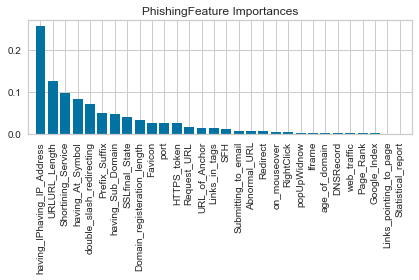

Running KMeans- cluster size: 2
Running KMeans- cluster size: 3
Running KMeans- cluster size: 4
Running KMeans- cluster size: 5
Running KMeans- cluster size: 6
Running KMeans- cluster size: 7
Running KMeans- cluster size: 8
Running KMeans- cluster size: 9
Running KMeans- cluster size: 10
Running KMeans- cluster size: 11
Running KMeans- cluster size: 12
Running KMeans- cluster size: 13
Running KMeans- cluster size: 14
Running KMeans- cluster size: 15
Running KMeans- cluster size: 16
Running KMeans- cluster size: 17
Running KMeans- cluster size: 18
Running KMeans- cluster size: 19
Running KMeans- cluster size: 20
Running KMeans- cluster size: 21
Running KMeans- cluster size: 22
Running KMeans- cluster size: 23
Running KMeans- cluster size: 24
Running KMeans- cluster size: 25
Running KMeans- cluster size: 26
Running KMeans- cluster size: 27
Running KMeans- cluster size: 28
Running KMeans- cluster size: 29
Running KMeans- cluster size: 30
Phishing F1-score: KMeans0.957576527372031
Running 

<Figure size 432x288 with 0 Axes>

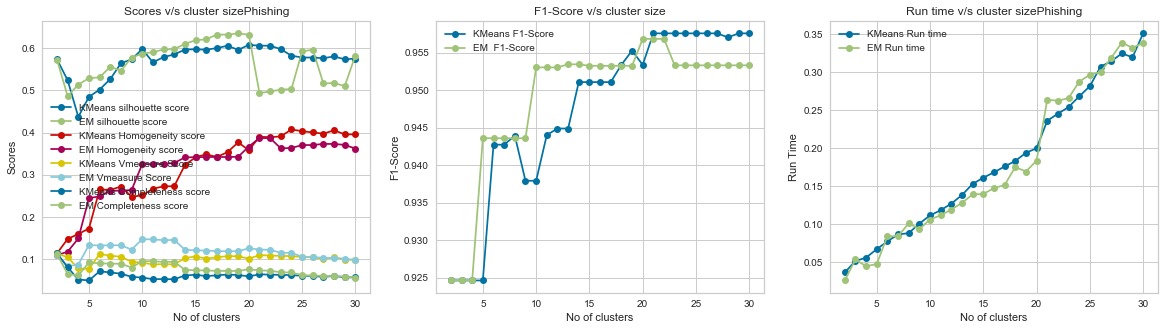

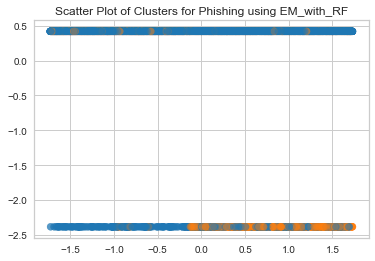

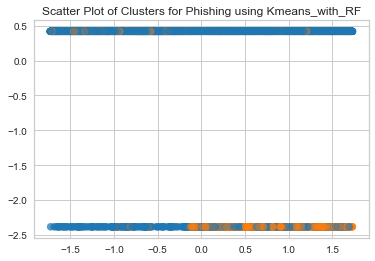

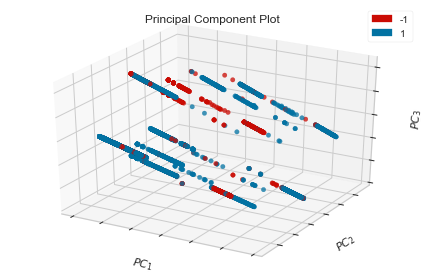

In [52]:
Dimensionality_reduction(x_phish_train, y_phish_train, 'Phishing', 'RF')

In [87]:
X, y, X_train, X_test, y_train, y_test = feature_engineering('Wine',NN=True)

Number of rows in wine quality dataset:  6497
Number of attributes in wine quality dataset:  13


In [90]:
    mlp_train_acc_lst = []
    mlp_test_acc_lst = []
    dataset ='Wine'
    max_itr = 1000
    lrng_rates = [0.0001,0.001, 0.005, 0.01]

    for lr in lrng_rates:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        mlp_train_acc_lst[len(mlp_train_acc_lst):]=[classifier.score(X_train, y_train)]
        mlp_test_acc_lst[len(mlp_test_acc_lst):]=[classifier.score(X_test, y_test)]

        
    pca_train_acc_lst = []
    pca_test_acc_lst = []
    pca_fitted_x = PCA().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(pca_fitted_x, y, test_size=0.2, random_state=7)
    for lr in lrng_rates:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        pca_train_acc_lst[len(pca_train_acc_lst):]=[classifier.score(X_train, y_train)]
        pca_test_acc_lst[len(pca_test_acc_lst):]=[classifier.score(X_test, y_test)]
        
    ica_train_acc_lst = []
    ica_test_acc_lst = []
    ica_fitted_x = FastICA(whiten=True, n_components = 8).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(ica_fitted_x, y, test_size=0.2, random_state=7)
    for lr in lrng_rates:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        ica_train_acc_lst[len(ica_train_acc_lst):]=[classifier.score(X_train, y_train)]
        ica_test_acc_lst[len(ica_test_acc_lst):]=[classifier.score(X_test, y_test)]

    rp_train_acc_lst = []
    rp_test_acc_lst = []
    rp_fitted_x = SparseRandomProjection(n_components=8).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(rp_fitted_x, y, test_size=0.2, random_state=7)
    for lr in lrng_rates:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        rp_train_acc_lst[len(rp_train_acc_lst):]=[classifier.score(X_train, y_train)]
        rp_test_acc_lst[len(rp_test_acc_lst):]=[classifier.score(X_test, y_test)]

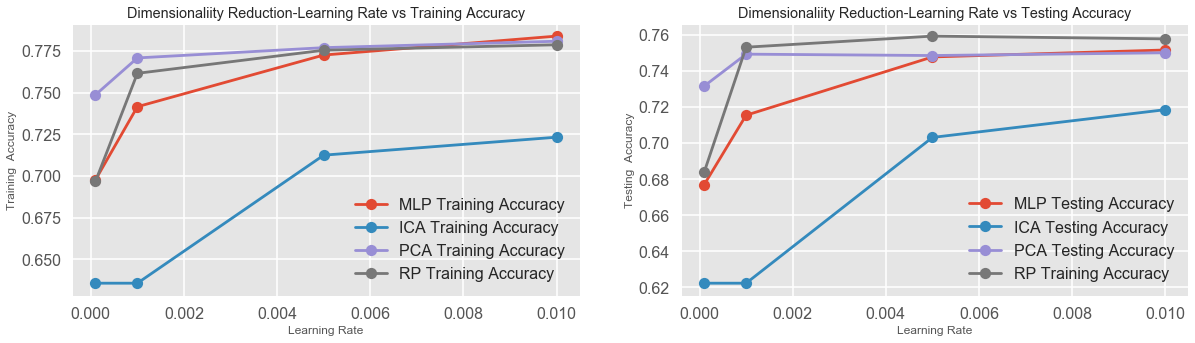

In [91]:
    _, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].set_title("Dimensionaliity Reduction-Learning Rate vs Training Accuracy")
    axes[0].set_xlabel("Learning Rate")
    axes[0].set_ylabel("Training  Accuracy")
    axes[0].plot(lrng_rates, mlp_train_acc_lst, linestyle='-', marker='o', label="MLP Training Accuracy")
    axes[0].plot(lrng_rates, ica_train_acc_lst, linestyle='-', marker='o', label="ICA Training Accuracy")
    axes[0].plot(lrng_rates, pca_train_acc_lst, linestyle='-', marker='o', label="PCA Training Accuracy")
    axes[0].plot(lrng_rates, rp_train_acc_lst, linestyle='-', marker='o', label="RP Training Accuracy")
    axes[0].legend(loc='best')
    axes[1].set_title("Dimensionaliity Reduction-Learning Rate vs Testing Accuracy")
    axes[1].set_xlabel("Learning Rate")
    axes[1].set_ylabel("Testing  Accuracy")
    axes[1].plot(lrng_rates, mlp_test_acc_lst, linestyle='-', marker='o', label="MLP Testing Accuracy")
    axes[1].plot(lrng_rates, ica_test_acc_lst, linestyle='-', marker='o', label="ICA Testing Accuracy")
    axes[1].plot(lrng_rates, pca_test_acc_lst, linestyle='-', marker='o', label="PCA Testing Accuracy")
    axes[1].plot(lrng_rates, rp_test_acc_lst, linestyle='-', marker='o', label="RP Training Accuracy")
    axes[1].legend(loc='best')
    saveFigPath = "figures/" + str(dataset) + "-DR-lrngvsaccuracy.png"
    plt.savefig(saveFigPath)
    plt.show()
    plt.close()

In [93]:
    km_train_acc_lst = []
    km_test_acc_lst = []
    kMeansModel = KMeans(n_clusters=2, max_iter=2000, n_init=100)
    yPredicted = kMeansModel.fit_predict(X)
    labels = pd.get_dummies(yPredicted)
    newX = np.concatenate((X, labels), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.2, random_state=7)
    for lr in lrng_rates:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        km_train_acc_lst[len(km_train_acc_lst):]=[classifier.score(X_train, y_train)]
        km_test_acc_lst[len(km_test_acc_lst):]=[classifier.score(X_test, y_test)]


    mlp_train_acc_lst.clear()
    mlp_test_acc_lst.clear()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    for lr in lrng_rates:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        mlp_train_acc_lst[len(mlp_train_acc_lst):]=[classifier.score(X_train, y_train)]
        mlp_test_acc_lst[len(mlp_test_acc_lst):]=[classifier.score(X_test, y_test)]

    em_train_acc_lst = []
    em_test_acc_lst = []
    expMaxModel = GaussianMixture(n_components=X.shape[1], max_iter=3000, n_init=50)
    yPredicted = expMaxModel.fit_predict(X)
    labels = pd.get_dummies(yPredicted)
    newX = np.concatenate((X, labels), axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.2, random_state=7)
    for lr in lrng_rates:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        em_train_acc_lst[len(em_train_acc_lst):]=[classifier.score(X_train, y_train)]
        em_test_acc_lst[len(em_test_acc_lst):]=[classifier.score(X_test, y_test)]

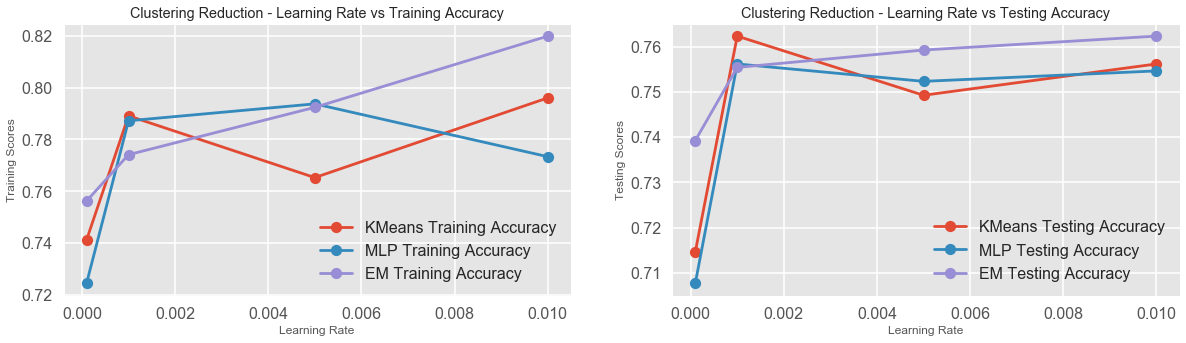

In [94]:
    _, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].set_title("Clustering Reduction - Learning Rate vs Training Accuracy")
    axes[0].set_xlabel("Learning Rate")
    axes[0].set_ylabel("Training Scores")
    axes[0].plot(lrng_rates, km_train_acc_lst, linestyle='-', marker='o', label="KMeans Training Accuracy")
    axes[0].plot(lrng_rates, mlp_train_acc_lst, linestyle='-', marker='o', label="MLP Training Accuracy")
    axes[0].plot(lrng_rates, em_train_acc_lst, linestyle='-', marker='o', label="EM Training Accuracy")
    axes[0].legend(loc='best')

    axes[1].set_title("Clustering Reduction - Learning Rate vs Testing Accuracy")
    axes[1].set_xlabel("Learning Rate")
    axes[1].set_ylabel("Testing Scores")
    axes[1].plot(lrng_rates, km_test_acc_lst, linestyle='-', marker='o', label="KMeans Testing Accuracy")
    axes[1].plot(lrng_rates, mlp_test_acc_lst, linestyle='-', marker='o', label="MLP Testing Accuracy")
    axes[1].plot(lrng_rates, em_test_acc_lst, linestyle='-', marker='o', label="EM Testing Accuracy")
    axes[1].legend(loc='best')
    saveFigPath = "figures/" + str(dataset) + "-Clustering-Learning-RatevsTestingScore.png"
    plt.savefig(saveFigPath)
    plt.show()
    plt.close()

In [119]:
def Nueral_Network(X, y, X_train, X_test, y_train, y_test, dataset):
    mlp_train_acc_lst = []
    mlp_test_acc_lst = []
    pca_train_acc_lst = []
    pca_test_acc_lst = []
    ica_train_acc_lst = []
    ica_test_acc_lst = []
    rp_train_acc_lst = []
    rp_test_acc_lst = []
    km_train_acc_lst = []
    km_test_acc_lst = []
    em_train_acc_lst = []
    em_test_acc_lst = []

    max_itrs = [1000, 2000, 3000, 4000]
    lr = 0.05

    for max_itr in max_itrs:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        mlp_train_acc_lst[len(mlp_train_acc_lst):]=[classifier.score(X_train, y_train)]
        mlp_test_acc_lst[len(mlp_test_acc_lst):]=[classifier.score(X_test, y_test)]
        
    pca_fitted_x = PCA().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(pca_fitted_x, y, test_size=0.2, random_state=7)
    for max_itr in max_itrs:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        pca_train_acc_lst[len(pca_train_acc_lst):]=[classifier.score(X_train, y_train)]
        pca_test_acc_lst[len(pca_train_acc_lst):]=[classifier.score(X_test, y_test)]

    ica_fitted_x = FastICA(whiten=True, n_components = 8).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(ica_fitted_x, y, test_size=0.2, random_state=7)
    for max_itr in max_itrs:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        ica_train_acc_lst[len(ica_train_acc_lst):]=[classifier.score(X_train, y_train)]
        ica_test_acc_lst[len(ica_test_acc_lst):]=[classifier.score(X_test, y_test)]


    rp_fitted_x = SparseRandomProjection(n_components=8).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(rp_fitted_x, y, test_size=0.2, random_state=7)
    for max_itr in max_itrs:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        rp_train_acc_lst[len(rp_train_acc_lst):]=[classifier.score(X_train, y_train)]
        rp_test_acc_lst[len(rp_test_acc_lst):]=[classifier.score(X_test, y_test)]

    _, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].set_title("Dimensionaliity Reduction-Max Iteration vs Training Accuracy")
    axes[0].set_xlabel("Max Iterations")
    axes[0].set_ylabel("Training Accuracy")
    axes[0].plot(max_itrs, mlp_train_acc_lst, linestyle='-', marker='o', label="MLP Training Accuracy")
    axes[0].plot(max_itrs, ica_train_acc_lst, linestyle='-', marker='o', label="ICA Training Accuracy")
    axes[0].plot(max_itrs, pca_train_acc_lst, linestyle='-', marker='o', label="PCA Training Accuracy")
    axes[0].plot(max_itrs, rp_train_acc_lst, linestyle='-', marker='o', label="RP Training Accuracy")
    axes[0].legend(loc='best')

    axes[1].set_title("Dimensionaliity Reduction-Max Iteration vs Testing Accuracy")
    axes[1].set_xlabel("Max Iterations")
    axes[1].set_ylabel("Testing Accuracy")
    axes[1].plot(max_itrs, mlp_test_acc_lst, linestyle='-', marker='o', label="MLP Testing Accuracy")
    axes[1].plot(max_itrs, ica_test_acc_lst, linestyle='-', marker='o', label="ICA Testing Accuracy")
    axes[1].plot(max_itrs, pca_test_acc_lst,linestyle='-', marker='o', label="PCA Testing Accuracy")
    axes[1].plot(max_itrs, rp_test_acc_lst, linestyle='-', marker='o', label="RP Testing Accuracy")
    axes[1].legend(loc='best')
    saveFigPath = "figures/" + str(dataset) + "-DRmaxitrvsacc.png"
    plt.savefig(saveFigPath)
    plt.show()
    plt.close()
    
    kMeansModel = KMeans(n_clusters=2, max_iter=3000, n_init=50)
    yPredicted = kMeansModel.fit_predict(X)
    labels = pd.get_dummies(yPredicted)
    newX = np.concatenate((X, labels), axis=1)


    X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.2, random_state=7)
    for max_itr in max_itrs:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        km_train_acc_lst[len(km_train_acc_lst):]=[classifier.score(X_train, y_train)]
        km_test_acc_lst[len(km_test_acc_lst):]=[classifier.score(X_test, y_test)]

    mlp_train_acc_lst.clear()
    mlp_test_acc_lst.clear()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    for max_itr in max_itrs:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        mlp_train_acc_lst[len(mlp_train_acc_lst):]=[classifier.score(X_train, y_train)]
        mlp_test_acc_lst[len(mlp_test_acc_lst):]=[classifier.score(X_test, y_test)]

    expMaxModel = GaussianMixture(n_components=X.shape[1], max_iter=3000, n_init=50)
    yPredicted = expMaxModel.fit_predict(X)
    labels = pd.get_dummies(yPredicted)
    newX = np.concatenate((X, labels), axis=1)

    X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.2, random_state=7)
    for max_itr in max_itrs:
        classifier = MLPClassifier(learning_rate_init=lr, max_iter=max_itr, early_stopping=True)
        classifier.fit(X_train, y_train)
        em_train_acc_lst[len(em_train_acc_lst):]=[classifier.score(X_train, y_train)]
        em_test_acc_lst[len(em_test_acc_lst):]=[classifier.score(X_test, y_test)]

    plt.figure(figsize=(20, 5))
    plt.title("Clustering Reduction - Max Iter vs Accuracy")
    plt.xlabel("Max Iterations")
    plt.ylabel("Accuracy")
    plt.plot(max_itrs, km_train_acc_lst, linestyle='-', marker='o', label="KMeans Training Accuracy")
    plt.plot(max_itrs, km_test_acc_lst, linestyle='-', marker='o', label="KMeans Testing Accuracy")
    plt.plot(max_itrs, em_train_acc_lst, linestyle='-', marker='o', label="EM Training Accuracy")
    plt.plot(max_itrs, em_test_acc_lst,linestyle='-', marker='o', label="EM Testing Accuracy")
    plt.plot(max_itrs, mlp_train_acc_lst,linestyle='-', marker='o', label="MLP Training Accuracy")
    plt.plot(max_itrs, mlp_test_acc_lst, linestyle='-', marker='o', label="MLP Testing Accuracy")
    plt.legend(loc='best')
    saveFigPath = "figures/" + str(dataset) + "-Clusteringitrvsacc.png"
    plt.savefig(saveFigPath)
    plt.show()
    plt.close()

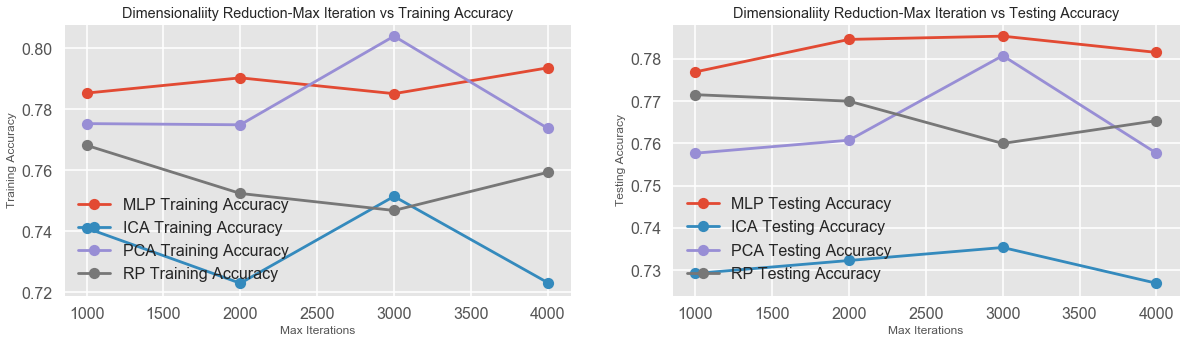

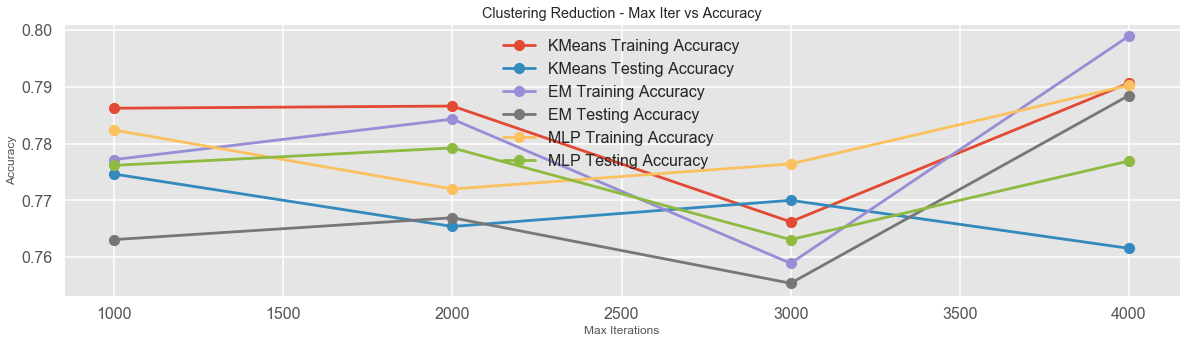

In [117]:
Nueral_Network(X_wine,y_wine,x_wine_train, x_wine_test, y_wine_train, y_wine_test, "wine")